The simplest approach for extracting information is a simple color extraction which can be used to detect land cover classes distinguished by color such as fields and waters. However, textural areas such as marshes can not be detected this way.

All these extractions are done with white-balance corrected images.

In [ ]:
import cv2
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

Text(0.5, 1.0, '213408_1965.tif')

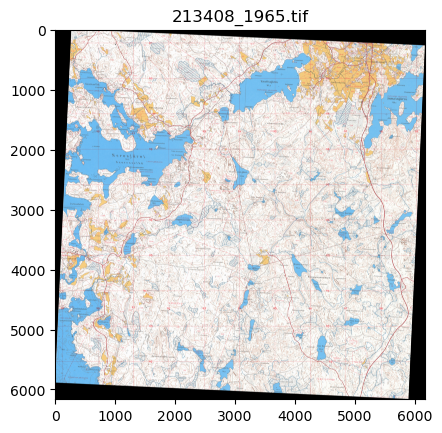

In [ ]:
datapath = Path('../data/maps/aligned_maps/')
files = sorted(os.listdir(datapath))
ex_file = cv2.imread(str(datapath/files[3]))
plt.imshow(cv2.cvtColor(ex_file, cv2.COLOR_BGR2RGB))
plt.title(files[4])

For easier color filtering, images are transformed into HSV colorspace

Text(0.5, 1.0, '213408_1965.tif')

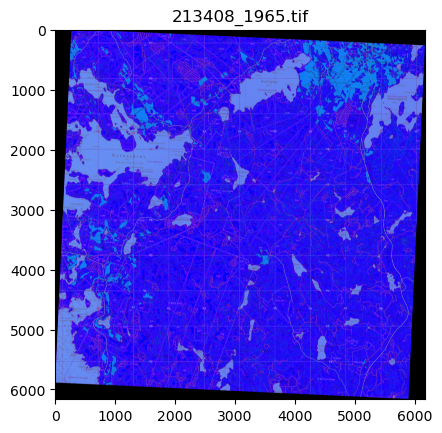

In [ ]:
hsv_ex = cv2.cvtColor(ex_file, cv2.COLOR_BGR2HSV)
plt.imshow(hsv_ex)
plt.title(files[4])

# Fields

HSV-range for fields is between `[10, 100, 100]` and `[25, 255, 255]`

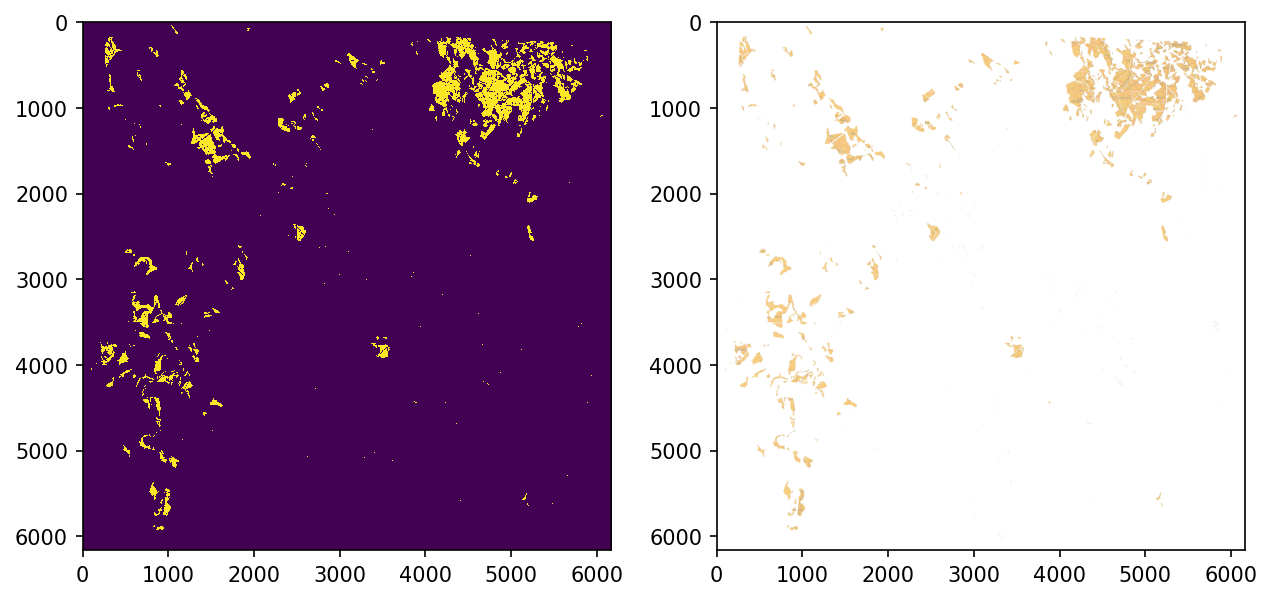

In [ ]:
hsv_field_bot = np.array([10,100,100])
hsv_field_top = np.array([25,255,255])
field_mask = cv2.inRange(hsv_ex, hsv_field_bot, hsv_field_top)
field_mask = field_mask.astype(np.int16)
fig, axs = plt.subplots(1,2, figsize=(10,6), dpi=150)
field_mask[field_mask<128] = 0
field_mask[field_mask>128] = 1
axs[0].imshow(field_mask, interpolation='none')
temp = ex_file.copy()
temp[field_mask == 0] = 255
axs[1].imshow(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
plt.show()

<matplotlib.image.AxesImage>

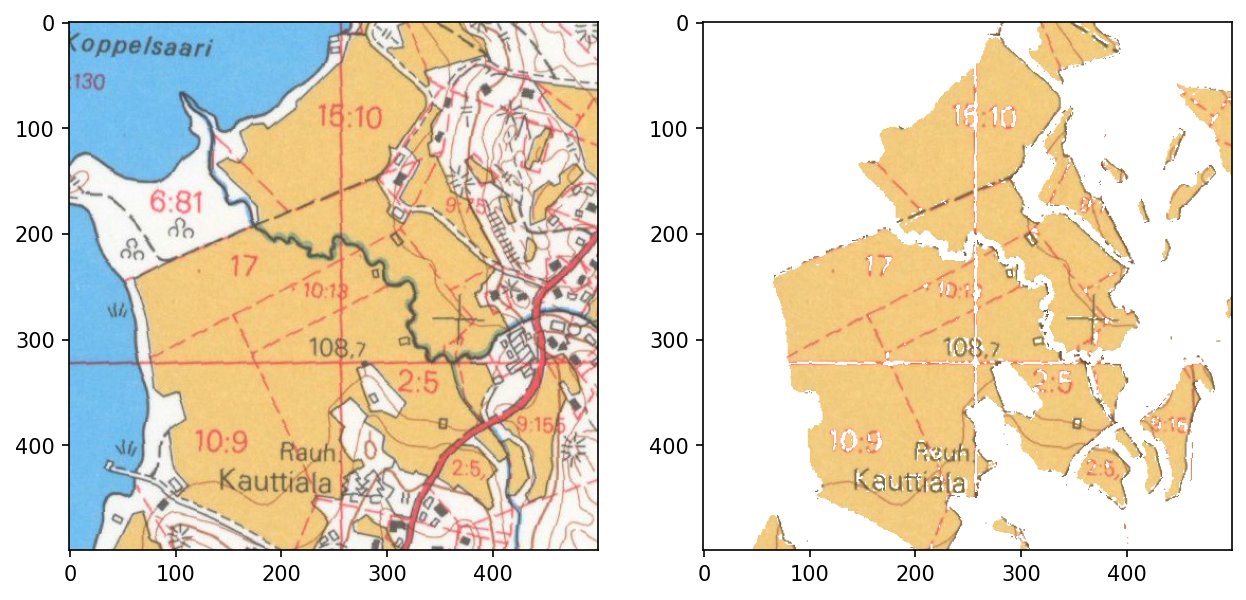

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,6), dpi=150)
axs[0].imshow(cv2.cvtColor(ex_file[500:1000, 4000:4500], cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(temp[500:1000, 4000:4500], cv2.COLOR_BGR2RGB))

# Waters

Water range is between `[60,10,10]` aand `[130,255,255]`.

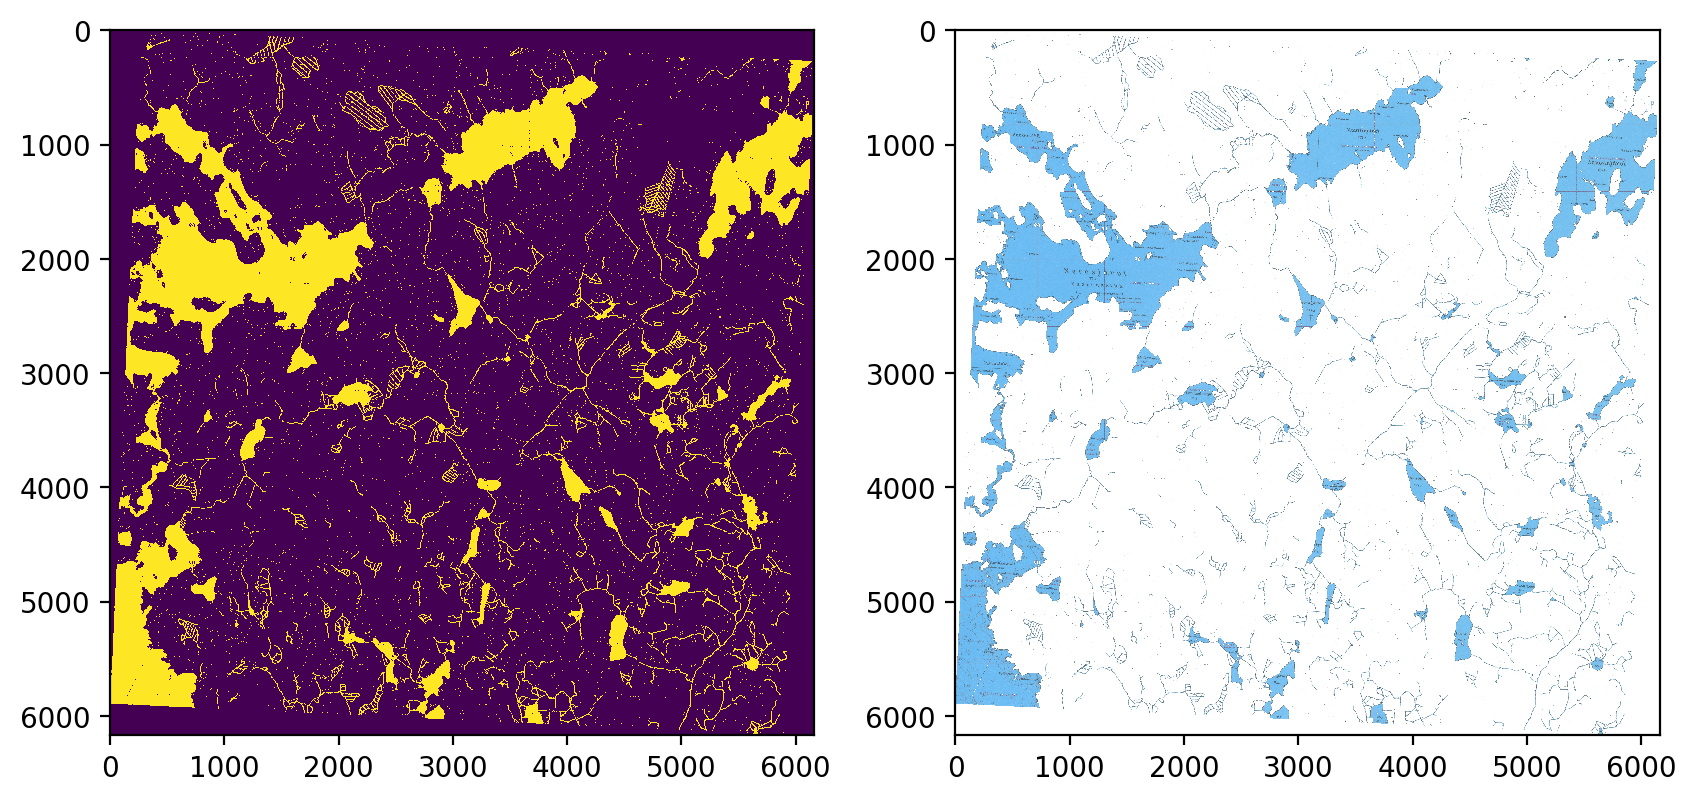

In [ ]:
hsv_water_bot = np.array([60,10,10])
hsv_water_top = np.array([130,255,255])
water_mask = cv2.inRange(hsv_ex, hsv_water_bot, hsv_water_top)
water_mask = water_mask.astype(np.uint8)
water_mask = water_mask
fig, axs = plt.subplots(1,2, figsize=(10,6), dpi=200)
water_mask[water_mask<128] = 0
water_mask[water_mask>128] = 1
axs[0].imshow(water_mask, interpolation='none')
temp = ex_file.copy()
temp[water_mask == 0] = 255
axs[1].imshow(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB), interpolation='none')
plt.show()

This approach, however, has some difficulties with ditches running through fields as their color is greenish rather than blue.

<matplotlib.image.AxesImage>

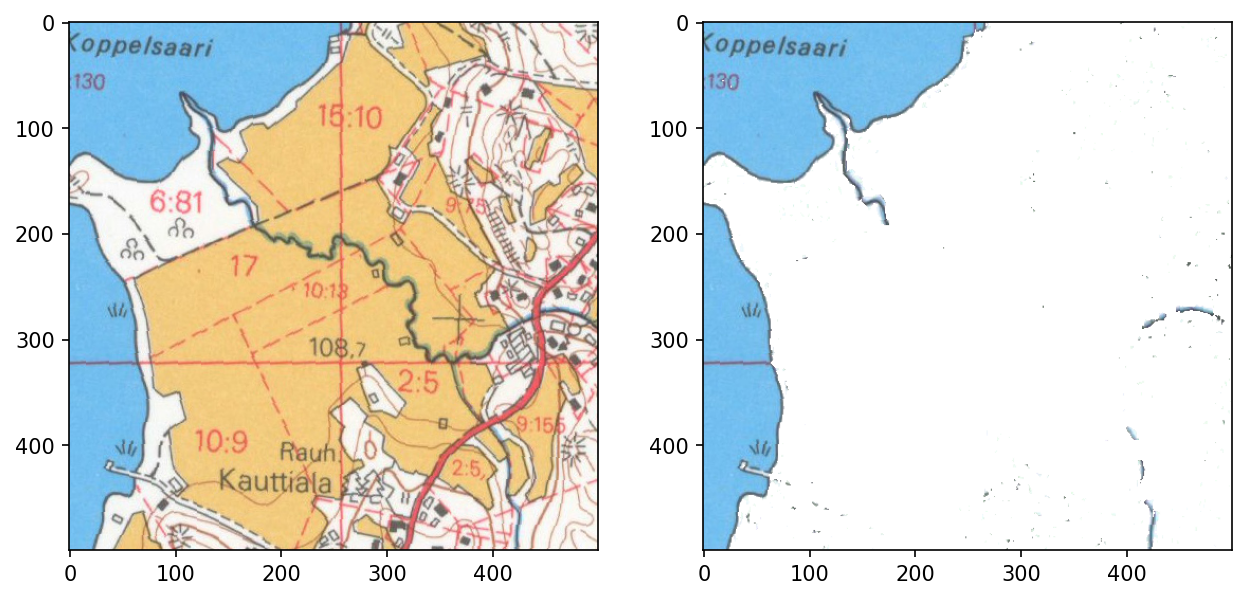

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,6), dpi=150)
axs[0].imshow(cv2.cvtColor(ex_file[500:1000, 4000:4500], cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(temp[500:1000, 4000:4500], cv2.COLOR_BGR2RGB))

Also, overlapping colors are fairly difficult situations.

<matplotlib.image.AxesImage>

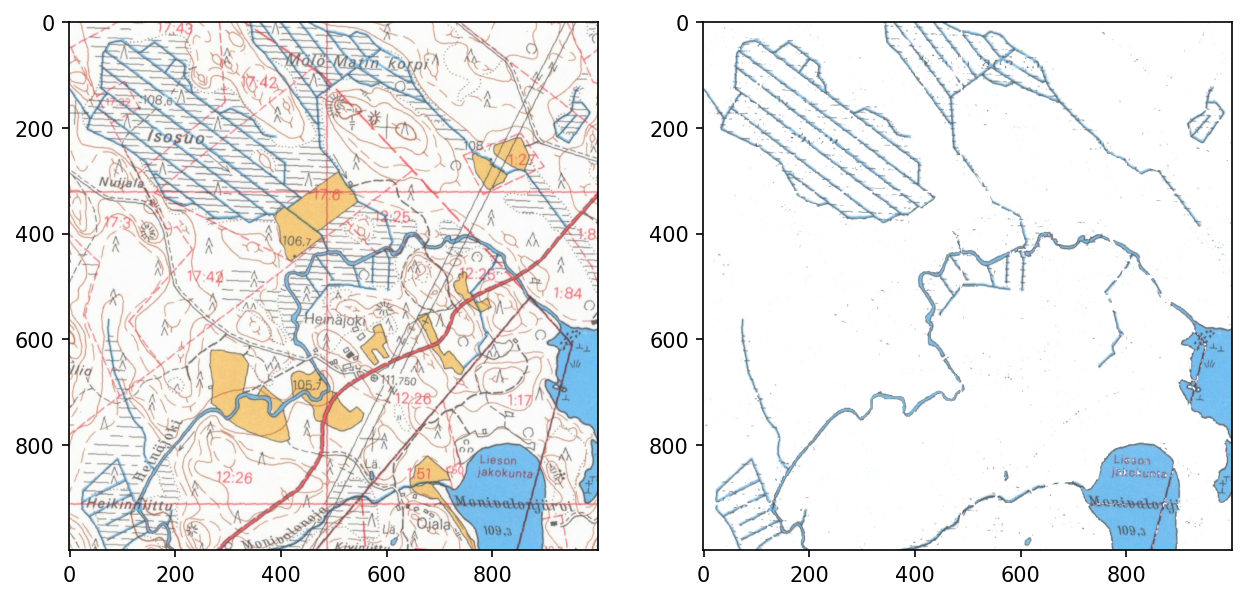

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10,6), dpi=150)
axs[0].imshow(cv2.cvtColor(ex_file[500:1500, 2000:3000], cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(temp[500:1500, 2000:3000], cv2.COLOR_BGR2RGB))

Distinguishing between water bodies and waterways can be done fairly easily with `MORPH_OPEN`.

Text(0.5, 1.0, 'Waterways')

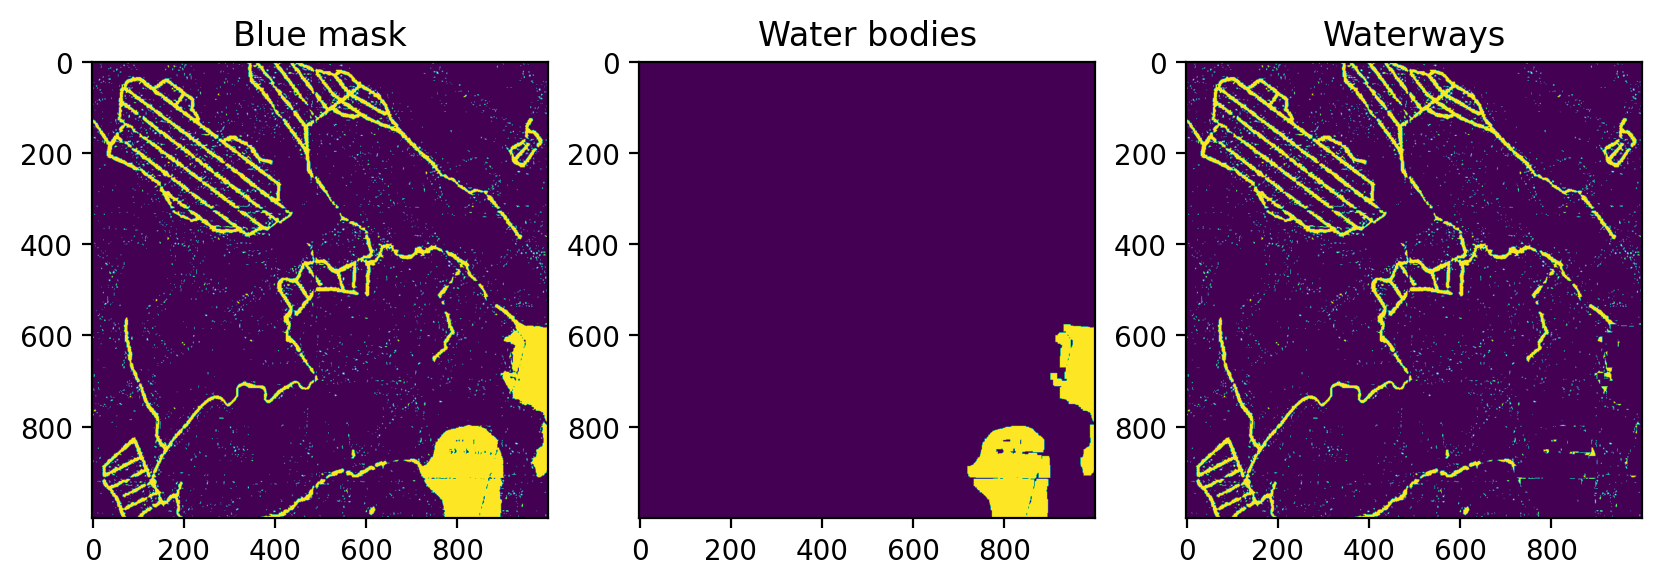

In [ ]:
water_mask_open = cv2.morphologyEx(water_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_RECT, (15,15)))
fig, axs = plt.subplots(1, 3, dpi=200, figsize=(10,6))
axs[0].imshow(water_mask[500:1500, 2000:3000])
axs[0].set_title('Blue mask')
axs[1].imshow(water_mask_open[500:1500, 2000:3000])
axs[1].set_title('Water bodies')
axs[2].imshow((water_mask - water_mask_open)[500:1500, 2000:3000])
axs[2].set_title('Waterways')

After some post-processing the waterway-layer looks fairly good.

Text(0.5, 1.0, 'Skeletonized waterways')

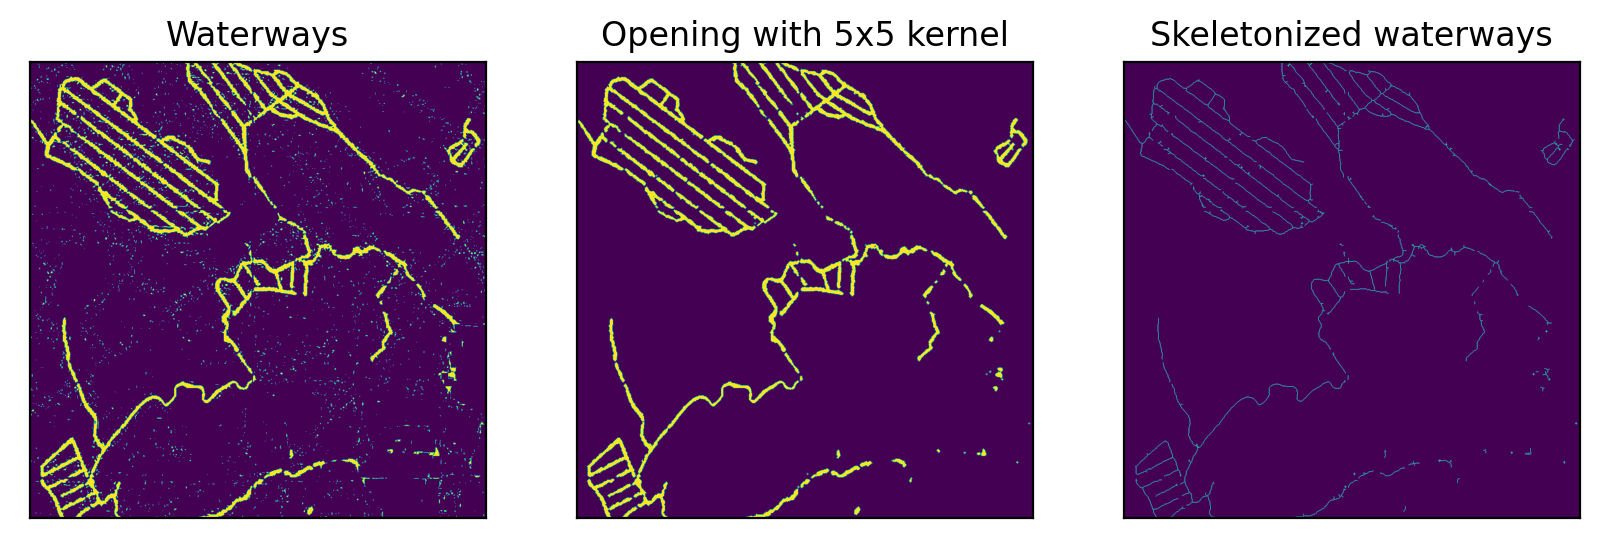

In [ ]:
from skimage.morphology import skeletonize

fig, axs = plt.subplots(1,3, dpi=200, figsize=(10,4))
for a in axs:
    a.set_xticks([])
    a.set_yticks([])

waterways = (water_mask - water_mask_open)[500:1500, 2000:3000]
axs[0].imshow(waterways)
axs[0].set_title('Waterways')
opened = cv2.morphologyEx(waterways, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_CROSS, (5,5)))
axs[1].imshow(opened)
axs[1].set_title('Opening with 5x5 kernel')
axs[2].imshow(skeletonize(opened))
axs[2].set_title('Skeletonized waterways')

# Roads

As red wraps around 180 in HSV-colorspace, two ranges are required for it.

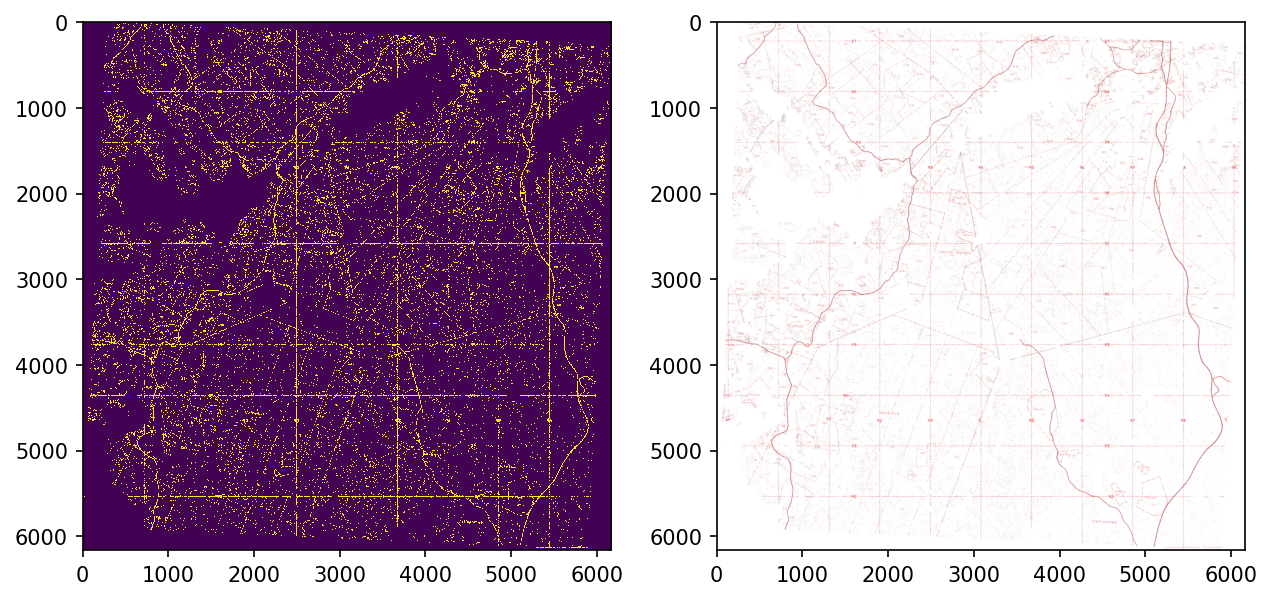

In [ ]:
hsv_red_bot1 = np.array([0,10,10])
hsv_red_top1 = np.array([5,255,255])
hsv_red_bot2 = np.array([175,10,10])
hsv_red_top2 = np.array([180,255,255])
red_mask1 = cv2.inRange(hsv_ex, hsv_red_bot1, hsv_red_top1)
red_mask1 = red_mask1.astype(np.int16)
red_mask2 = cv2.inRange(hsv_ex, hsv_red_bot2, hsv_red_top2)
red_mask2 = red_mask2.astype(np.int16)
fig, axs = plt.subplots(1,2, figsize=(10,6), dpi=150)
red_mask = red_mask1 | red_mask2
red_mask[red_mask<128] = 0
red_mask[red_mask>128] = 1
axs[0].imshow(red_mask, interpolation='none')
temp = ex_file.copy()
temp[red_mask == 0] = 255
axs[1].imshow(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
plt.show()

Another approach is to invert the RGB-image, convert it to HSV and look for cyan.

<matplotlib.image.AxesImage>

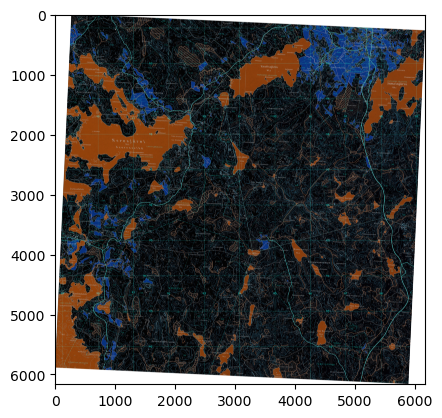

In [ ]:
plt.imshow(cv2.cvtColor(~ex_file, cv2.COLOR_BGR2RGB))

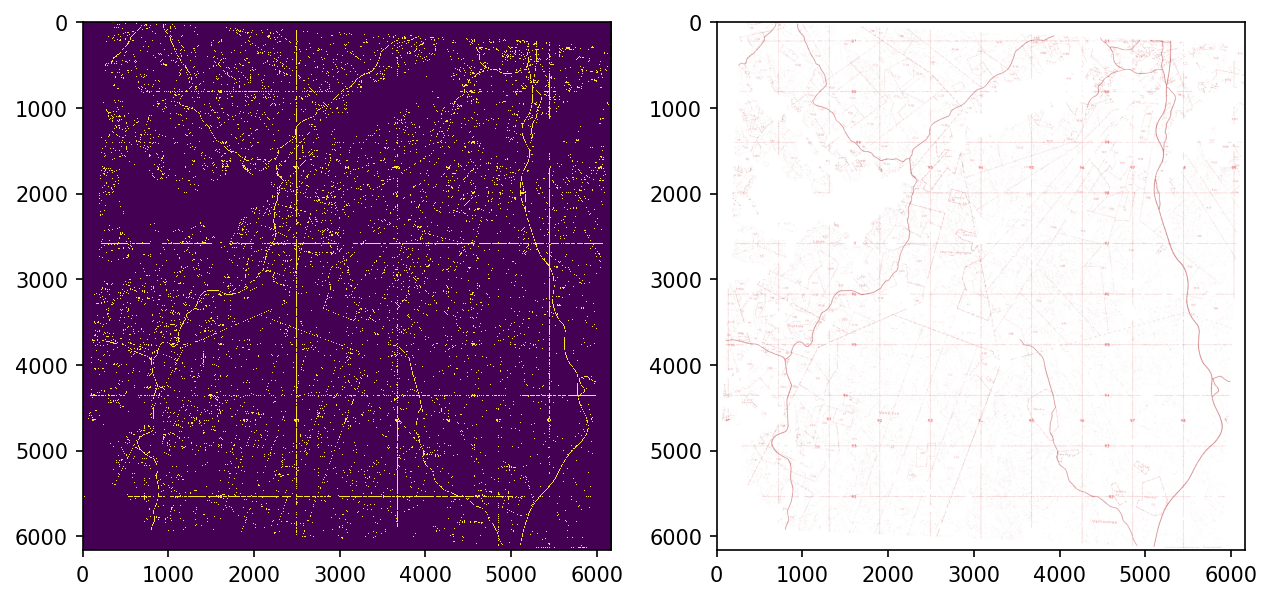

In [ ]:
inv_hsv = cv2.cvtColor(~ex_file, cv2.COLOR_BGR2HSV)
hsv_cyan_bot = np.array([85,70,50])
hsv_cyan_top = np.array([95,255,255])
cyan_mask = cv2.inRange(inv_hsv, hsv_cyan_bot, hsv_cyan_top)
cyan_mask = cyan_mask.astype(np.uint8)
fig, axs = plt.subplots(1,2, figsize=(10,6), dpi=150)
cyan_mask[cyan_mask<128] = 0
cyan_mask[cyan_mask>128] = 1
axs[0].imshow(cyan_mask, interpolation='none')
temp = ex_file.copy()
temp[cyan_mask == 0] = 255
axs[1].imshow(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
plt.show()

Unfortunately, there are lots of other things than roads that are red in the images. We can get rid of some of them with simple morphological opening but not nearly all of them.

<matplotlib.image.AxesImage>

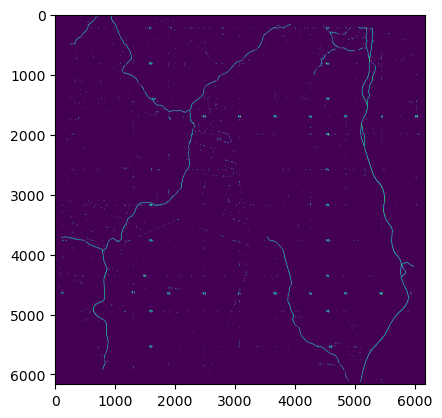

In [ ]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5,5))
opened = cv2.morphologyEx(cyan_mask, cv2.MORPH_OPEN, kernel)
plt.imshow(opened)